## Stock sentiment analysis

### Goal
Determine the sentiment of tweets about various stocks or financial news

### Type of problem
This is a **classification** problem, with a binary target variable determininng if the message has a postive sentiment or negative sentiment




Import the different libraries

In [1]:
%reset -f

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [4]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

plt.rcParams['legend.fontsize'] = 12
plt.rcParams['font.size'] = 14

plt.rcParams['lines.markersize'] = 8

In [5]:
### Flags
save_figs = True

In [6]:
from sklearn.base import clone

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, ShuffleSplit, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [8]:
import re
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

### Models

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process.kernels import RBF

from sklearn.naive_bayes import GaussianNB

In [10]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score

In [11]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint, uniform, loguniform
from sklearn.tree import plot_tree

In [14]:
import eli5

Using TensorFlow backend.


## Custom code for Tree prunning and plots

In [15]:
from mlgtsrc import bank_data, plots
import os
import pickle

In [312]:
OUTFIGURES = "../../report/figures/stock"

## Initial Data Exploration

### Read the input file

In [232]:
import os
src = "./data/"
filename = "stock_data.csv"

In [233]:
raw = pd.read_csv(os.path.join(src, filename))

In [234]:
raw.head()

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


In [235]:
raw.columns = ['msge', 'target']

In [236]:
raw.loc[:, 'target'] = raw.loc[:, 'target'].astype(int)

In [237]:
raw.loc[:, 'target'] = [1 if x == 1 else 0 for x in raw.loc[:, 'target']]

In [238]:
raw.loc[raw.loc[:, 'target']==0, :]

,msge,target
6,AAP - user if so then the current downtrend wi...,0
7,Monday's relative weakness. NYX WIN TIE TAP IC...,0
21,Won't believe AAP uptrend is back until it cro...,0
26,"red, not ready for break out.",0
31,user: been adding VXY long off the bottom toda...,0
...,...,...
5781,#CoronavirusPandemic \n\nAs bad as #China's ec...,0
5782,#China #CoronavirusPandemic \n\nThe economy wa...,0
5784,Goldman Sachs tells investors to go defensive ...,0
5786,Industry body CII said #discoms are likely to ...,0


In [239]:
raw.loc[raw.loc[:, 'target']==1, :]

,msge,target
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1
...,...,...
5783,"Reliance Industries raises Rs 8,500 crore usin...",1
5785,"#TCS #share price jumps 9% on no #layoffs, #di...",1
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1


In [304]:
x=raw['msge'].copy()
y=raw['target'].copy()

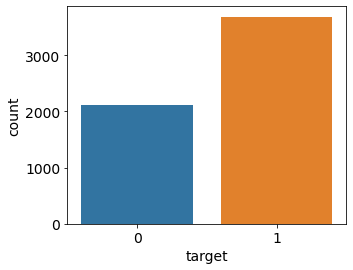

In [315]:
fig, ax = plt.subplots(1, 1, figsize = (5, 4))
sns.countplot(x=raw.loc[:, 'target'], ax = ax)
fig.savefig(os.path.join(os.path.join(OUTFIGURES, "stock_sentiment_number_classes.png")))

In [314]:
os.path.join(os.path.join(OUTFIGURES, "stock_sentiment_number_classes.png"))

'../../report/figures/stock\\stock_sentiment_number_classes.png'

In [242]:
processed = raw.copy()
processed.loc[:, 'msge length'] = [len(x) for x in processed.loc[:, 'msge']]


In [243]:
processed.groupby('target').describe()

msge length                                                     
             count       mean        std  min   25%   50%    75%    max
target                                                                 
0           2106.0  81.505223  38.697109  8.0  51.0  82.0  113.0  150.0
1           3685.0  76.794844  36.547817  6.0  46.0  78.0  103.0  154.0

In [244]:
print(f"{2106.0/len(raw):2.1%} of the tweets have negative sentiment")

36.4% of the tweets have negative sentiment


In [245]:
contractions = { 
"ain't": "am not","aren't": "are not","can't": "cannot","can't've": "cannot have",
"'cause": "because","could've": "could have","couldn't": "could not","couldn't've": "could not have",
"didn't": "did not","doesn't": "does not","don't": "do not","hadn't": "had not",
"hadn't've": "had not have","hasn't": "has not","haven't": "have not","he'd": "he would",
"he'd've": "he would have","he'll": "he will","he's": "he is","how'd": "how did",
"how'll": "how will","how's": "how is","i'd": "i would","i'll": "i will",
"i'm": "i am","i've": "i have","isn't": "is not","it'd": "it would","it'll": "it will",
"it's": "it is","let's": "let us","ma'am": "madam","mayn't": "may not",
"might've": "might have","mightn't": "might not","must've": "must have","mustn't": "must not",
"needn't": "need not","oughtn't": "ought not","shan't": "shall not","sha'n't": "shall not",
"she'd": "she would","she'll": "she will","she's": "she is","should've": "should have",
"shouldn't": "should not","that'd": "that would","that's": "that is","there'd": "there had",
"there's": "there is","they'd": "they would","they'll": "they will","they're": "they are",
"they've": "they have","wasn't": "was not","we'd": "we would","we'll": "we will",
"we're": "we are","we've": "we have","weren't": "were not","what'll": "what will",
"what're": "what are","what's": "what is","what've": "what have","where'd": "where did",
"where's": "where is","who'll": "who will","who's": "who is","won't": "will not",
"wouldn't": "would not","you'd": "you would","you'll": "you will","you're": "you are"
}

In [246]:
# Convert words to lower case
for i in range(len(x)):
    text = re.sub('[^a-zA-Z]',' ',x[i])
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text=text.lower()
    text=word_tokenize(text)
    stemmer=PorterStemmer()
    stopword = set(stopwords.words("english"))
    text=[stemmer.stem(words) for words in text if words not in stopword]
    x[i]=' '.join(text)
    
    # Replace contractions with their longer forms 
    if True:
        #text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        x[i]= " ".join(new_text)

### See how many unique tokens we have on the whole text

In [247]:
CountVectorizer().fit_transform(x).toarray().shape

(5791, 7161)

### Vectorize the data
Only use data from the training set

### Split the data

In [248]:
X_train,X_test, y_train, y_test= train_test_split(x,y, test_size= 0.1, random_state=30)

In [249]:
#Only use data from the training set to vectorize
in_sample_vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train).toarray()

### Obtaint the test set

In [250]:
X_test = vectorizer.transform(X_test).toarray()

## Base algorithms

Run learning curve, validation curve and running time across a set of base algorithms

In [156]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

In [157]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process.kernels import RBF

from sklearn.naive_bayes import GaussianNB

In [158]:
# Parameters 
#train_sizes = np.linspace(0.2, 1.0, 5)
train_sizes = [100, 300, 500, 1000, 2000, 3000, 4000]
n_jobs      = -1
scoring     = 'roc_auc'

### Decision Tree

In [159]:
results = {}

In [160]:
cv          = 5

algoData = (bank_data.PrunedTree(), "Decision tree - Max Depth", 'max_depth', [10, 20, 30, 40, 50, 60])

baseAlgo, algoName, param_name, param_range = algoData

learning_curve_data = learning_curve(
                                    baseAlgo,
                                    X_train,
                                    y_train,
                                    cv=cv,
                                    n_jobs=n_jobs,
                                    train_sizes=train_sizes,
                                    return_times=True,
                                    scoring = scoring
                                    )

validation_curve_data = validation_curve(
                                    baseAlgo,
                                    X_train,
                                    y_train,
                                    param_name=param_name,
                                    param_range=param_range,
                                    scoring=scoring,
                                    n_jobs=n_jobs,
                                )

results[algoName] = {'learning': learning_curve_data, 'validation': validation_curve_data,
                    'algoData': algoData}

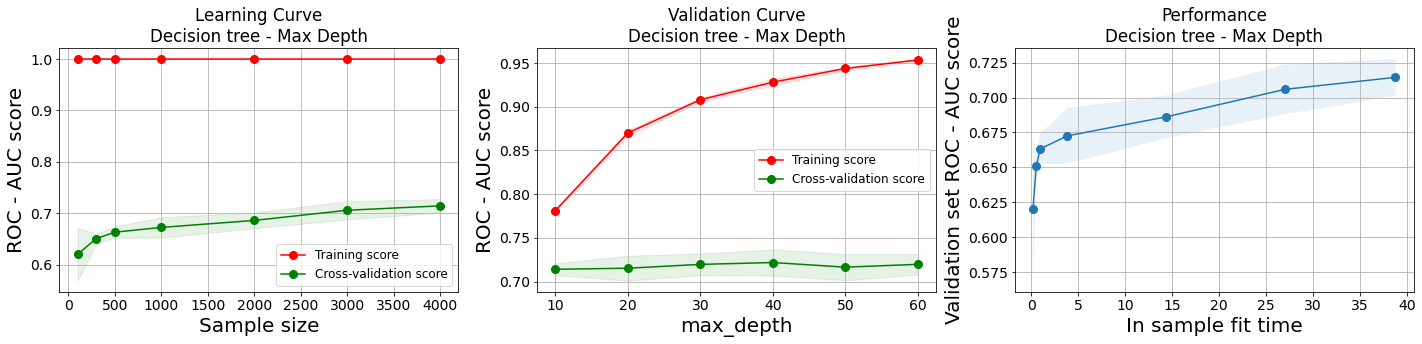

In [161]:
algoName = "Decision tree - Max Depth"

algoData = results[algoName]['algoData']
figure = plt.figure(figsize = (20, 5))
# Plot Learning curve
title = 'Learning Curve\n' + algoName
ax = figure.add_subplot(1, 3, 1)
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotLearningCurve(train_sizes, train_scores, test_scores, ax, title, ylabel = 'ROC - AUC score')

# Validation Curve
title = 'Validation Curve\n' + algoName
ax = figure.add_subplot(1, 3, 2)
param_range = algoData[3]
train_scores, test_scores = results[algoName]['validation']

param_name = algoData[2]
plots.plotValidationCurve(param_range, train_scores, test_scores, ax, title, xlabel = param_name, ylabel = 'ROC - AUC score')

# Score vs Fit-Time
title = 'Performance\n' + algoName
ax = figure.add_subplot(1, 3, 3)
param_range = algoData[3]
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotScoreVsFitTime(fit_times, test_scores, ax, title, ylabel = 'Validation set ROC - AUC score')
figure.tight_layout()
figure.savefig(os.path.join(os.path.join(OUTFIGURES, "tree_val_curves_max_width.png")))

### Decision tree - change the prune level

In [163]:
cv          = 10

algoData = (bank_data.PrunedTree(pruneLevel = 10), "Decision tree - Prunning", 'pruneLevel', [10,
                                                                                              20, 
                                                                                              30, 
                                                                                              40, 
                                                                                              50, 
                                                                                              60])

baseAlgo, algoName, param_name, param_range = algoData

learning_curve_data = learning_curve(
                                    baseAlgo,
                                    X_train,
                                    y_train,
                                    cv=cv,
                                    n_jobs=n_jobs,
                                    train_sizes=train_sizes,
                                    return_times=True,
                                    scoring = scoring
                                    )

validation_curve_data = validation_curve(
                                    baseAlgo,
                                    X_train,
                                    y_train,
                                    param_name=param_name,
                                    param_range=param_range,
                                    scoring=scoring,
                                    n_jobs=n_jobs,
                                )

results[algoName] = {'learning': learning_curve_data, 'validation': validation_curve_data,
                    'algoData': algoData}

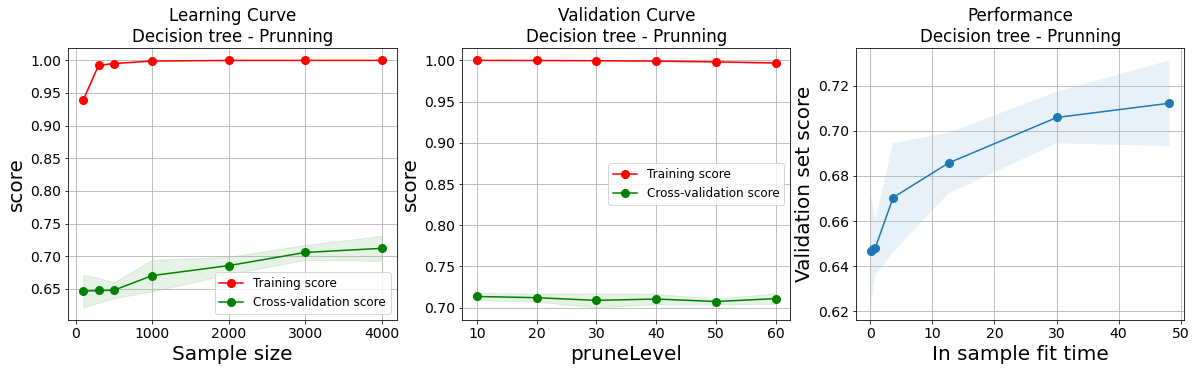

In [164]:
algoName = "Decision tree - Prunning"

algoData = results[algoName]['algoData']
figure = plt.figure(figsize = (20, 5))
# Plot Learning curve
title = 'Learning Curve\n' + algoName
ax = figure.add_subplot(1, 3, 1)
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotLearningCurve(train_sizes, train_scores, test_scores, ax, title)

# Validation Curve
title = 'Validation Curve\n' + algoName
ax = figure.add_subplot(1, 3, 2)
param_range = algoData[3]
train_scores, test_scores = results[algoName]['validation']

param_name = algoData[2]
plots.plotValidationCurve(param_range, train_scores, test_scores, ax, title, xlabel = param_name)

# Score vs Fit-Time
title = 'Performance\n' + algoName
ax = figure.add_subplot(1, 3, 3)
param_range = algoData[3]
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotScoreVsFitTime(fit_times, test_scores, ax, title)


#### Combine the max depth with the prune level

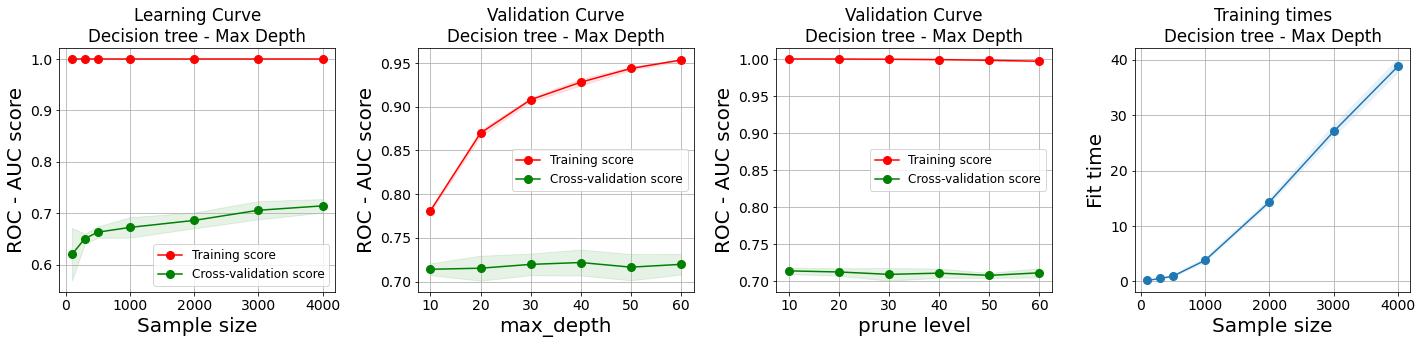

In [165]:
algoName = "Decision tree - Max Depth"

algoData = results[algoName]['algoData']
figure = plt.figure(figsize = (20, 5))
# Plot Learning curve
title = 'Learning Curve\n' + algoName
ax = figure.add_subplot(1, 4, 1)
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotLearningCurve(train_sizes, train_scores, test_scores, ax, title, ylabel = 'ROC - AUC score')

# Validation Curve - max depth
title = 'Validation Curve\n' + algoName
ax = figure.add_subplot(1, 4, 2)
param_range = algoData[3]
train_scores, test_scores = results[algoName]['validation']

param_name = algoData[2]
plots.plotValidationCurve(param_range, train_scores, test_scores, ax, title, xlabel = param_name, ylabel = 'ROC - AUC score')


# Validation Curve - prune
title = 'Validation Curve\n' + algoName
ax = figure.add_subplot(1, 4, 3)
param_range = results["Decision tree - Prunning"]['algoData'][3]
train_scores, test_scores = results["Decision tree - Prunning"]['validation']

param_name = algoData[2]
plots.plotValidationCurve(param_range, train_scores, test_scores, ax, title, xlabel = "prune level", ylabel = 'ROC - AUC score')



# Score vs Fit-Time
#title = 'Performance\n' + algoName
#ax = figure.add_subplot(1, 4, 4)
#param_range = algoData[3]
#train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
#plots.plotScoreVsFitTime(fit_times, test_scores, ax, title, ylabel = 'Validation set ROC - AUC score')

#figure.tight_layout()
#figure.savefig(os.path.join(os.path.join(OUTFIGURES, "tree_val_curves_max_width_prune_level.png")))


# Score vs Fit-Time
title = 'Training times\n' + algoName
ax = figure.add_subplot(1, 4, 4)
param_range = algoData[3]
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotSampleSizeVsFitTime(train_sizes, fit_times, ax, title)

figure.tight_layout()
figure.savefig(os.path.join(os.path.join(OUTFIGURES, "tree_val_curves_max_width_prune_level.png")))




#### Combine the max depth with the prune level, and plot it differently, in terms of pruning

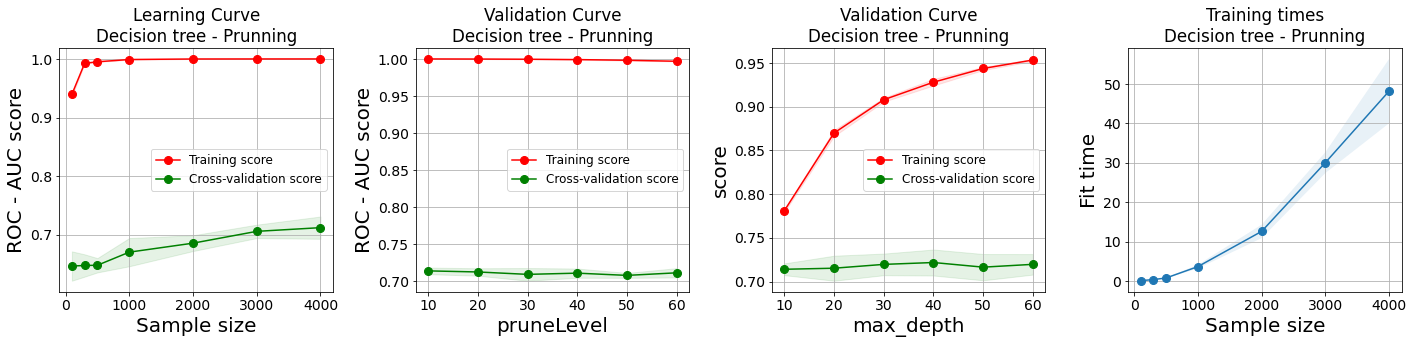

In [166]:
algoName = "Decision tree - Prunning"

algoData = results[algoName]['algoData']
figure = plt.figure(figsize = (20, 5))
# Plot Learning curve
title = 'Learning Curve\n' + algoName
ax = figure.add_subplot(1, 4, 1)
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotLearningCurve(train_sizes, train_scores, test_scores, ax, title, ylabel = 'ROC - AUC score')

# Validation Curve - max depth
title = 'Validation Curve\n' + algoName
ax = figure.add_subplot(1, 4, 2)
param_range = algoData[3]
train_scores, test_scores = results[algoName]['validation']

param_name = algoData[2]
plots.plotValidationCurve(param_range, train_scores, test_scores, ax, title, xlabel = param_name, ylabel = 'ROC - AUC score')


# Validation Curve
title = 'Validation Curve\n' + algoName
ax = figure.add_subplot(1, 4, 3)
param_range = results["Decision tree - Max Depth"]['algoData'][3]
train_scores, test_scores = results["Decision tree - Max Depth"]['validation']

param_name = algoData[2]
plots.plotValidationCurve(param_range, train_scores, test_scores, ax, title, xlabel = 'max_depth')


# Score vs Fit-Time
#title = 'Performance\n' + algoName
#ax = figure.add_subplot(1, 4, 4)
#param_range = algoData[3]
#train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
#plots.plotScoreVsFitTime(fit_times, test_scores, ax, title, ylabel = 'Validation set ROC - AUC score')

#figure.tight_layout()
#figure.savefig(os.path.join(os.path.join(OUTFIGURES, "tree_val_curves_max_width_prune_level.png")))


# Score vs Fit-Time
title = 'Training times\n' + algoName
ax = figure.add_subplot(1, 4, 4)
param_range = algoData[3]
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotSampleSizeVsFitTime(train_sizes, fit_times, ax, title)

figure.tight_layout()
figure.savefig(os.path.join(os.path.join(OUTFIGURES, "tree_val_curves_max_width_prune_level.png")))




### Neural Network - depth

In [168]:
cv = 5
algoData = (MLPClassifier(hidden_layer_sizes = (10,)), "Neural Network - depth", 'hidden_layer_sizes', [(10,),                                                                                                         
                                                                                                        (10, 10, 10), 
                                                                                                        (10, 10, 10, 10, 10),
                                                                                                        (10, 10, 10, 10, 10, 10, 10),
                                                                                                        (10, 10, 10, 10, 10, 10, 10, 10, 10, 10),
                                                                                                        (10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10)
                                                                                                       ])

baseAlgo, algoName, param_name, param_range = algoData

learning_curve_data = learning_curve(
                                    baseAlgo,
                                    X_train,
                                    y_train,
                                    cv=cv,
                                    n_jobs=n_jobs,
                                    train_sizes=train_sizes,
                                    return_times=True,
                                    scoring = scoring
                                    )

validation_curve_data = validation_curve(
                                    baseAlgo,
                                    X_train,
                                    y_train,
                                    param_name=param_name,
                                    param_range=param_range,
                                    scoring=scoring,
                                    n_jobs=n_jobs,
                                )

results[algoName] = {'learning': learning_curve_data, 'validation': validation_curve_data,
                    'algoData': algoData}

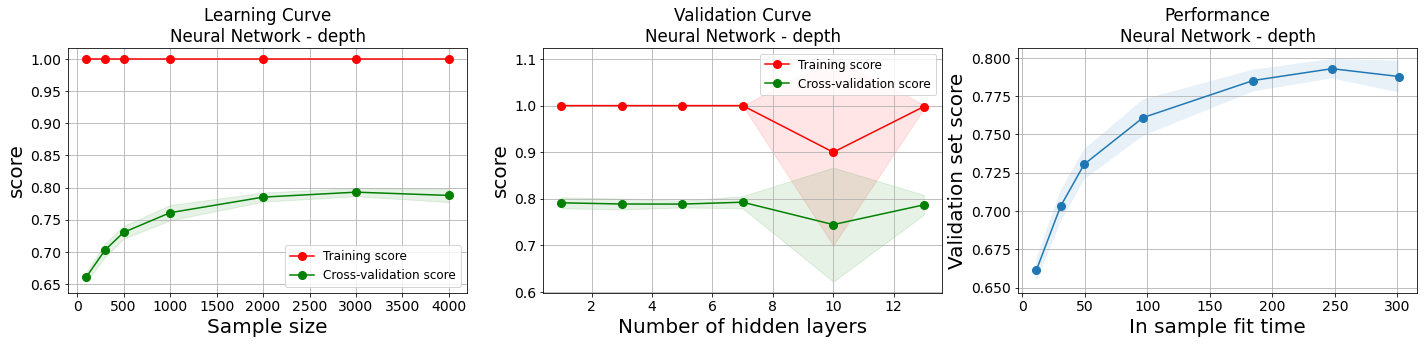

In [169]:
algoName = "Neural Network - depth"

algoData = results[algoName]['algoData']
figure = plt.figure(figsize = (20, 5))
# Plot Learning curve
title = 'Learning Curve\n' + algoName
ax = figure.add_subplot(1, 3, 1)
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotLearningCurve(train_sizes, train_scores, test_scores, ax, title)

# Validation Curve
title = 'Validation Curve\n' + algoName
ax = figure.add_subplot(1, 3, 2)
param_range = [len(layer) for layer in algoData[3]]
train_scores, test_scores = results[algoName]['validation']
xlabel = "Number of hidden layers"
plots.plotValidationCurve(param_range, train_scores, test_scores, ax, title, xlabel = xlabel)

# Score vs Fit-Time
title = 'Performance\n' + algoName
ax = figure.add_subplot(1, 3, 3)
param_range = algoData[3]
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotScoreVsFitTime(fit_times, test_scores, ax, title)

figure.tight_layout()
figure.savefig(os.path.join(os.path.join(OUTFIGURES, "neuralnets_val_curves_depth.png")))

### Neural Network - width

In [170]:
cv = 5
algoData = (MLPClassifier(hidden_layer_sizes = (10,)), "Neural Network - width", 'hidden_layer_sizes', [(10,),                                                                                                                                                                                                                 
                                                                                                        (100, ),
                                                                                                        (200, ),
                                                                                                        (500, ),
                                                                                                       (1000, )])



baseAlgo, algoName, param_name, param_range = algoData

learning_curve_data = learning_curve(
                                    baseAlgo,
                                    X_train,
                                    y_train,
                                    cv=cv,
                                    n_jobs=n_jobs,
                                    train_sizes=train_sizes,
                                    return_times=True,
                                    scoring = scoring
                                    )

validation_curve_data = validation_curve(
                                    baseAlgo,
                                    X_train,
                                    y_train,
                                    param_name=param_name,
                                    param_range=param_range,
                                    scoring=scoring,
                                    n_jobs=n_jobs,
                                )

results[algoName] = {'learning': learning_curve_data, 'validation': validation_curve_data,
                    'algoData': algoData}

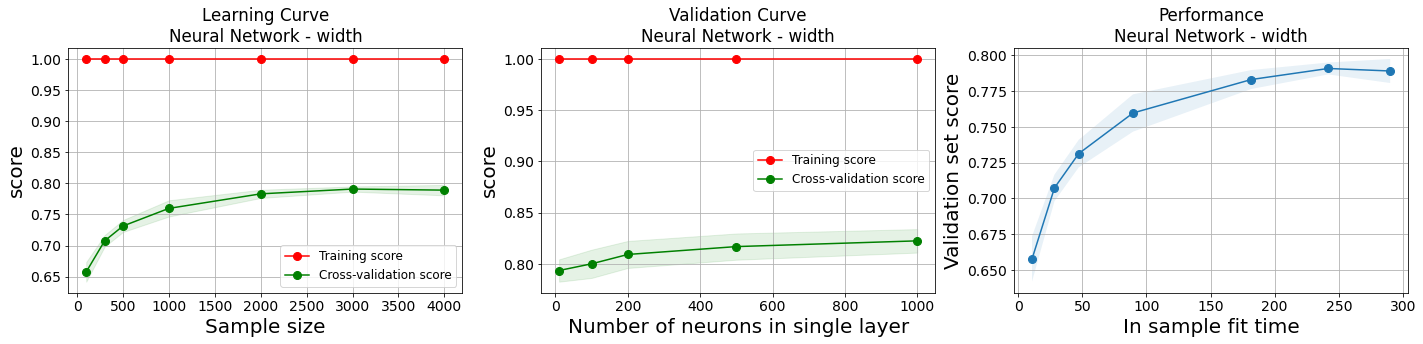

In [171]:
algoName = "Neural Network - width"

algoData = results[algoName]['algoData']
figure = plt.figure(figsize = (20, 5))
# Plot Learning curve
title = 'Learning Curve\n' + algoName
ax = figure.add_subplot(1, 3, 1)
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotLearningCurve(train_sizes, train_scores, test_scores, ax, title)

# Validation Curve
title = 'Validation Curve\n' + algoName
ax = figure.add_subplot(1, 3, 2)
param_range = [layer[0] for layer in algoData[3]]
train_scores, test_scores = results[algoName]['validation']
xlabel = "Number of neurons in single layer"
plots.plotValidationCurve(param_range, train_scores, test_scores, ax, title, xlabel = xlabel)

# Score vs Fit-Time
title = 'Performance\n' + algoName
ax = figure.add_subplot(1, 3, 3)
param_range = algoData[3]
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotScoreVsFitTime(fit_times, test_scores, ax, title)

figure.tight_layout()
figure.savefig(os.path.join(os.path.join(OUTFIGURES, "neuralnets_val_curves_width.png")))

#### Combine the depth and with of the Neural net

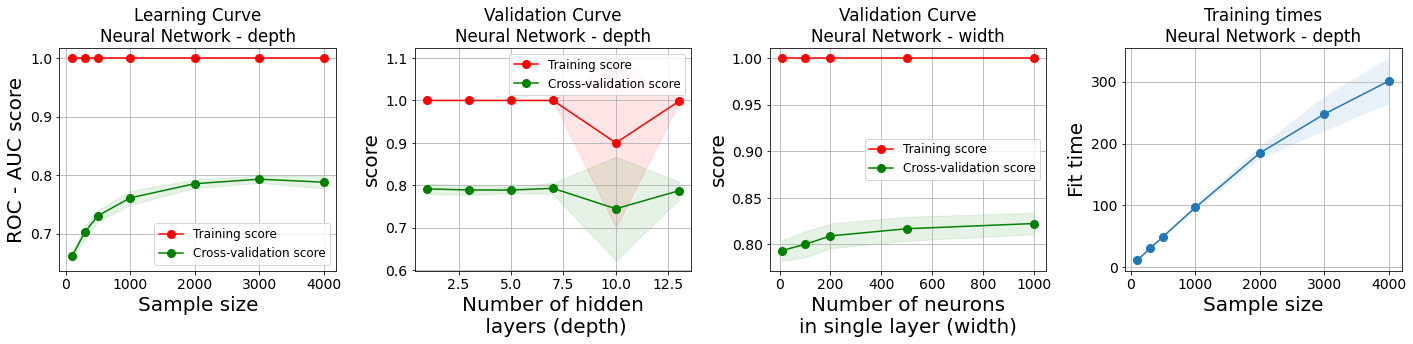

In [172]:
algoName = "Neural Network - depth"

algoData = results[algoName]['algoData']
figure = plt.figure(figsize = (20, 5))
# Plot Learning curve
title = 'Learning Curve\n' + algoName
ax = figure.add_subplot(1, 4, 1)
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotLearningCurve(train_sizes, train_scores, test_scores, ax, title, ylabel = 'ROC - AUC score')

# Validation Curve - Depth
title = 'Validation Curve\n' + algoName
ax = figure.add_subplot(1, 4, 2)
param_range = [len(layer) for layer in algoData[3]]
train_scores, test_scores = results[algoName]['validation']
xlabel = "Number of hidden\n layers (depth)"
plots.plotValidationCurve(param_range, train_scores, test_scores, ax, title, xlabel = xlabel)


# Validation Curve - Width
title = 'Validation Curve\n' + "Neural Network - width"
ax = figure.add_subplot(1, 4, 3)
param_range = [layer[0] for layer in results["Neural Network - width"]['algoData'][3]]
train_scores, test_scores = results["Neural Network - width"]['validation']
xlabel = "Number of neurons\nin single layer (width)"
plots.plotValidationCurve(param_range, train_scores, test_scores, ax, title, xlabel = xlabel)



# Score vs Fit-Time
#title = 'Performance\n' + algoName
#ax = figure.add_subplot(1, 4, 4)
#param_range = algoData[3]
#train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
#plots.plotScoreVsFitTime(fit_times, test_scores, ax, title, ylabel = 'Validation set\nROC-AUC score')


# Training time
title = 'Training times\n' + algoName
ax = figure.add_subplot(1, 4, 4)
param_range = algoData[3]
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotSampleSizeVsFitTime(train_sizes, fit_times, ax, title)


figure.tight_layout()
figure.savefig(os.path.join(os.path.join(OUTFIGURES, "neuralnets_val_curves_width_depth.png")))

### Boosting

In [173]:
cv = 10
algoData = (AdaBoostClassifier(n_estimators = 2), "AdaBoostClassifier", 'n_estimators', [2, 5, 10, 20, 50, 100, 200, 500])

baseAlgo, algoName, param_name, param_range = algoData

learning_curve_data = learning_curve(
                                    baseAlgo,
                                     X_train,
                                    y_train,
                                    cv=cv,
                                    n_jobs=n_jobs,
                                    train_sizes=train_sizes,
                                    return_times=True,
                                    scoring = scoring
                                    )

validation_curve_data = validation_curve(
                                    baseAlgo,
                                    X_train,
                                    y_train,
                                    param_name=param_name,
                                    param_range=param_range,
                                    scoring=scoring,
                                    n_jobs=n_jobs,
                                )

results[algoName] = {'learning': learning_curve_data, 'validation': validation_curve_data,
                    'algoData': algoData}

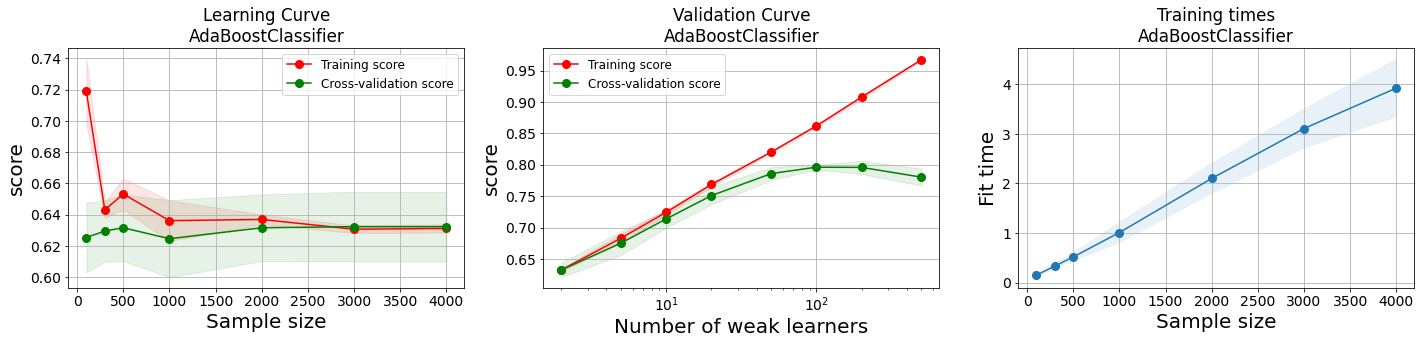

In [174]:
algoName = "AdaBoostClassifier"

algoData = results[algoName]['algoData']
figure = plt.figure(figsize = (20, 5))
# Plot Learning curve
title = 'Learning Curve\n' + algoName
ax = figure.add_subplot(1, 3, 1)
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotLearningCurve(train_sizes, train_scores, test_scores, ax, title)

# Validation Curve
title = 'Validation Curve\n' + algoName
ax = figure.add_subplot(1, 3, 2)
param_range = algoData[3]
train_scores, test_scores = results[algoName]['validation']
xlabel = "Number of weak learners"
plots.plotValidationCurve(param_range, train_scores, test_scores, ax, title, xlabel = xlabel, xscale = 'log')

# Score vs Fit-Time
#title = 'Performance\n' + algoName
#ax = figure.add_subplot(1, 3, 3)
#param_range = algoData[3]
#train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
#plots.plotScoreVsFitTime(fit_times, test_scores, ax, title)

# Training time
title = 'Training times\n' + algoName
ax = figure.add_subplot(1, 3, 3)
param_range = algoData[3]
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotSampleSizeVsFitTime(train_sizes, fit_times, ax, title)


figure.tight_layout()
figure.savefig(os.path.join(os.path.join(OUTFIGURES, "bossting_val_curves_numweaklearners.png")))

### SVC - Linear kernel

In [175]:
cv = 5

algoData = (SVC(kernel = 'linear', C = 0.01), "SVC - Linear kernel", 'C', [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 1.5])

baseAlgo, algoName, param_name, param_range = algoData

learning_curve_data = learning_curve(
                                    baseAlgo,
                                     X_train,
                                    y_train,
                                    cv=cv,
                                    n_jobs=n_jobs,
                                    train_sizes=train_sizes,
                                    return_times=True,
                                    scoring = scoring
                                    )

validation_curve_data = validation_curve(
                                    baseAlgo,
                                    X_train,
                                    y_train,
                                    param_name=param_name,
                                    param_range=param_range,
                                    scoring=scoring,
                                    n_jobs=n_jobs,
                                )

results[algoName] = {'learning': learning_curve_data, 'validation': validation_curve_data,
                    'algoData': algoData}

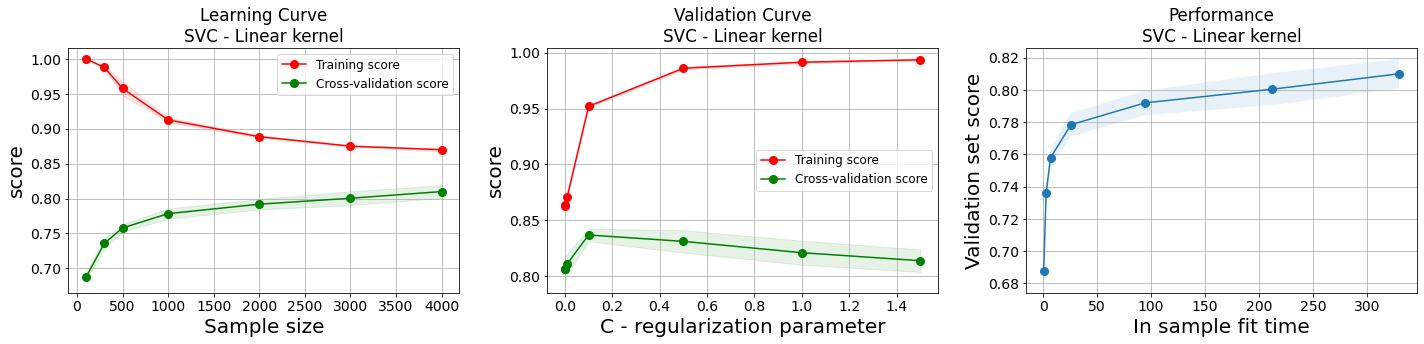

In [176]:
algoName = "SVC - Linear kernel"

algoData = results[algoName]['algoData']
figure = plt.figure(figsize = (20, 5))
# Plot Learning curve
title = 'Learning Curve\n' + algoName
ax = figure.add_subplot(1, 3, 1)
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotLearningCurve(train_sizes, train_scores, test_scores, ax, title)

# Validation Curve
title = 'Validation Curve\n' + algoName
ax = figure.add_subplot(1, 3, 2)
param_range = algoData[3]
train_scores, test_scores = results[algoName]['validation']
xlabel = "C - regularization parameter"
plots.plotValidationCurve(param_range, train_scores, test_scores, ax, title, xlabel = xlabel)

# Score vs Fit-Time
title = 'Performance\n' + algoName
ax = figure.add_subplot(1, 3, 3)
param_range = algoData[3]
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotScoreVsFitTime(fit_times, test_scores, ax, title)

figure.tight_layout()
figure.savefig(os.path.join(os.path.join(OUTFIGURES, "svc_val_curves_linear.png")))

### SVC - rbf

In [177]:
cv = 5
algoData = (SVC(kernel = 'rbf', C = 0.01), "SVC - Radial Basis Function", 'C', [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 1.5])

baseAlgo, algoName, param_name, param_range = algoData

learning_curve_data = learning_curve(
                                    baseAlgo,
                                     X_train,
                                    y_train,
                                    cv=cv,
                                    n_jobs=n_jobs,
                                    train_sizes=train_sizes,
                                    return_times=True,
                                    scoring = scoring
                                    )

validation_curve_data = validation_curve(
                                    baseAlgo,
                                    X_train,
                                    y_train,
                                    param_name=param_name,
                                    param_range=param_range,
                                    scoring=scoring,
                                    n_jobs=n_jobs,
                                )

results[algoName] = {'learning': learning_curve_data, 'validation': validation_curve_data,
                    'algoData': algoData}

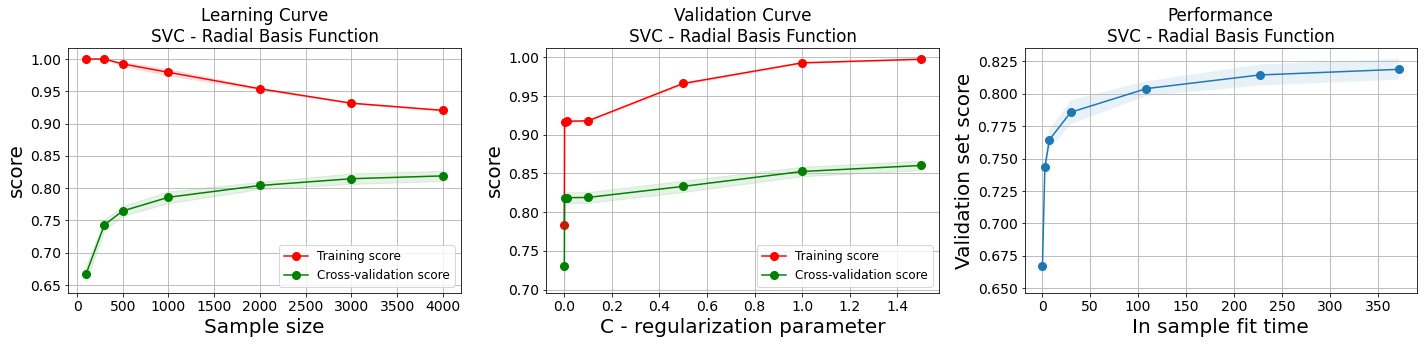

In [178]:
algoName = "SVC - Radial Basis Function"

algoData = results[algoName]['algoData']
figure = plt.figure(figsize = (20, 5))
# Plot Learning curve
title = 'Learning Curve\n' + algoName
ax = figure.add_subplot(1, 3, 1)
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotLearningCurve(train_sizes, train_scores, test_scores, ax, title)

# Validation Curve
title = 'Validation Curve\n' + algoName
ax = figure.add_subplot(1, 3, 2)
param_range = algoData[3]
train_scores, test_scores = results[algoName]['validation']
xlabel = "C - regularization parameter"
plots.plotValidationCurve(param_range, train_scores, test_scores, ax, title, xlabel = xlabel)

# Score vs Fit-Time
title = 'Performance\n' + algoName
ax = figure.add_subplot(1, 3, 3)
param_range = algoData[3]
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotScoreVsFitTime(fit_times, test_scores, ax, title)

figure.tight_layout()
figure.savefig(os.path.join(os.path.join(OUTFIGURES, "svc_val_curves_rbf.png")))

#### Combine the different kernels

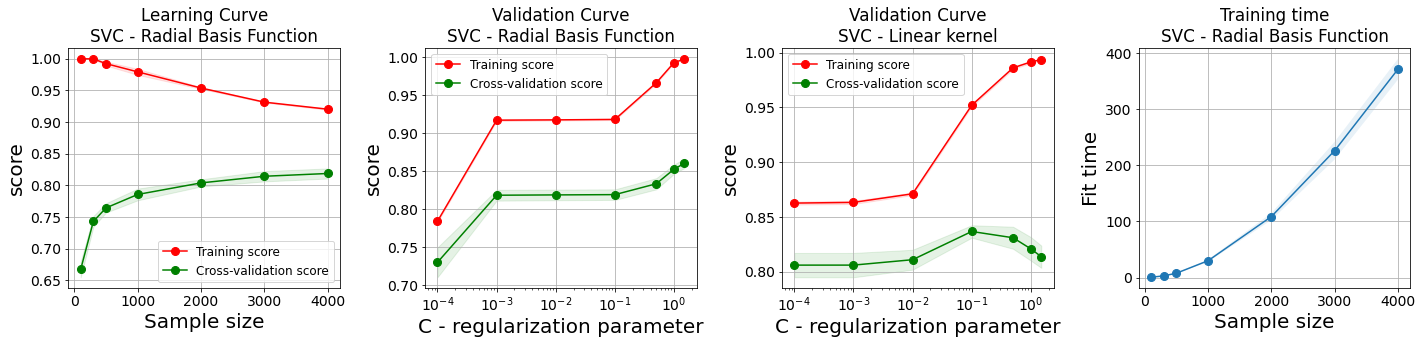

In [179]:
algoName = "SVC - Radial Basis Function"

algoData = results[algoName]['algoData']
figure = plt.figure(figsize = (20, 5))
# Plot Learning curve
title = 'Learning Curve\n' + algoName
ax = figure.add_subplot(1, 4, 1)
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotLearningCurve(train_sizes, train_scores, test_scores, ax, title)

# Validation Curve
title = 'Validation Curve\n' + algoName
ax = figure.add_subplot(1, 4, 2)
param_range = algoData[3]
train_scores, test_scores = results[algoName]['validation']
xlabel = "C - regularization parameter"
plots.plotValidationCurve(param_range, train_scores, test_scores, ax, title, xlabel = xlabel, xscale = 'log')

# Validation Curve
title = 'Validation Curve\n' + "SVC - Linear kernel"
ax = figure.add_subplot(1, 4, 3)
param_range = results["SVC - Linear kernel"]['algoData'][3]
train_scores, test_scores = results["SVC - Linear kernel"]['validation']
xlabel = "C - regularization parameter"
plots.plotValidationCurve(param_range, train_scores, test_scores, ax, title, xlabel = xlabel, xscale = 'log')


# Score vs Fit-Time
#title = 'Performance\n' + algoName
#ax = figure.add_subplot(1, 4, 4)
#param_range = algoData[3]
#train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
#plots.plotScoreVsFitTime(fit_times, test_scores, ax, title)

#figure.tight_layout()
#figure.savefig(os.path.join(os.path.join(OUTFIGURES, "svc_val_curves_rbf_linear.png")))

# Sample Size vs Fit-Time
title = 'Training time\n' + algoName
ax = figure.add_subplot(1, 4, 4)
param_range = algoData[3]
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotSampleSizeVsFitTime(train_sizes, fit_times, ax, title)

figure.tight_layout()
figure.savefig(os.path.join(os.path.join(OUTFIGURES, "svc_val_curves_rbf_linear.png")))

### K-NN

In [180]:
cv = 5
algoData = (KNeighborsClassifier(n_neighbors = 20), "K-NN", 'n_neighbors', [1, 5, 10, 20, 40, 50, 80, 100])

baseAlgo, algoName, param_name, param_range = algoData

learning_curve_data = learning_curve(
                                    baseAlgo,
                                     X_train,
                                    y_train,
                                    cv=cv,
                                    n_jobs=n_jobs,
                                    train_sizes=train_sizes,
                                    return_times=True,
                                    scoring = scoring
                                    )

validation_curve_data = validation_curve(
                                    baseAlgo,
                                    X_train,
                                    y_train,
                                    param_name=param_name,
                                    param_range=param_range,
                                    scoring=scoring,
                                    n_jobs=n_jobs,
                                )

results[algoName] = {'learning': learning_curve_data, 'validation': validation_curve_data,
                    'algoData': algoData}

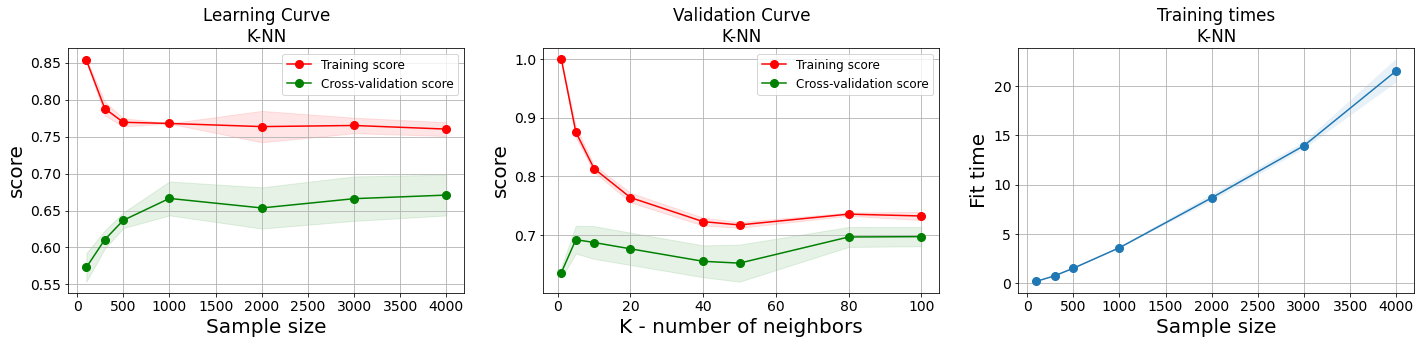

In [181]:
algoName = "K-NN"

algoData = results[algoName]['algoData']
figure = plt.figure(figsize = (20, 5))
# Plot Learning curve
title = 'Learning Curve\n' + algoName
ax = figure.add_subplot(1, 3, 1)
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotLearningCurve(train_sizes, train_scores, test_scores, ax, title)

# Validation Curve
title = 'Validation Curve\n' + algoName
ax = figure.add_subplot(1, 3, 2)
param_range = algoData[3]
train_scores, test_scores = results[algoName]['validation']
xlabel = "K - number of neighbors"
plots.plotValidationCurve(param_range, train_scores, test_scores, ax, title, xlabel = xlabel)

# Score vs Fit-Time
#title = 'Performance\n' + algoName
#ax = figure.add_subplot(1, 3, 3)
#param_range = algoData[3]
#train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
#plots.plotScoreVsFitTime(fit_times, test_scores, ax, title)

# Training time
title = 'Training times\n' + algoName
ax = figure.add_subplot(1, 3, 3)
train_sizes, train_scores, test_scores, fit_times, _ = results[algoName]['learning']
plots.plotSampleSizeVsFitTime(train_sizes, fit_times, ax, title)


figure.tight_layout()
figure.savefig(os.path.join(os.path.join(OUTFIGURES, "knn_val_curves_n.png")))

### Save the results

In [182]:
pickle.dump(results, open("stock_cross_model_study.pkl", "wb"))

In [183]:
### Load the results

#results = pickle.load(open("spam_cross_model_study.pkl", "rb"))

## Perform Random Grid Search to tune the parameter across each model

Set the distribution of parameters, based on the validation curves I have obtained before

In [184]:
randomSearchRes = {}

In [185]:
# Number of random searches
n_iter_search = 50

# Cross validation
cv = 4

# Scoring
scoring='roc_auc'



In [186]:
param_distribs = {'Classification Trees':{
                                            'min_samples_split': randint(low=1, high=1000),    
                                            'max_depth': randint(low=1, high=50),
                                            'pruneLevel': [None] + list(range(50)),
                                            },
                  'Neural Networks': {'hidden_layer_sizes' : [(2, ), 
                                                            (4, ), 
                                                            (8, ), 
                                                            (10, ), 
                                                            (20, ), 
                                                            (2, 2), 
                                                            (4, 2), 
                                                            (10, 5, 2), 
                                                           ]
                                     },
                  #'AdaBoosting': {'n_estimators': randint(low=10, high=1000)},
                  #'SVC': {'kernel': ['linear', 'rbf'], 'C':loguniform(a = 1e-5, b = 1e1)},
                  #'K-NN': {'n_neighbors': randint(low=1, high=500)}
                 }

In [187]:
for modelName, clfModel in [('Classification Trees', bank_data.PrunedTree(random_state=1)),                
                  
                ('Neural Networks', MLPClassifier()),
                  
                #('AdaBoosting', AdaBoostClassifier()),
                #('SVC', SVC()),
                  
                #('K-NN', KNeighborsClassifier())
                           ]:
    
    print(f'Doing {modelName}...')
    
    rnd_search = RandomizedSearchCV(clfModel, param_distributions=param_distribs[modelName],
                                    n_iter=n_iter_search, cv=cv, scoring=scoring, 
                                    random_state=1)

    random_search_res = rnd_search.fit(X_train, y_train)

    randomSearchRes[modelName] = random_search_res
    print(f'Doing {modelName}...Done!')
    

Doing Classification Trees...
Doing Classification Trees...Done!
Doing Neural Networks...


C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:282: UserWarning: The total space of parameters 8 is smaller than n_iter=50. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % sel

Doing Neural Networks...Done!
Doing AdaBoosting...


KeyboardInterrupt: 

### Sdaboosting SVC and K-NN were taking too long, reduce the number of iterations and ranges

In [189]:
# Number of random searches
n_iter_search = 20

# Cross validation
cv = 4

# Scoring
scoring='roc_auc'



In [190]:
param_distribs = {
    
                  'AdaBoosting': {'n_estimators': randint(low=10, high=150)},
                  'SVC': {'kernel': ['linear', 'rbf'], 'C':loguniform(a = 1e-5, b = 1e1)},
                  'K-NN': {'n_neighbors': randint(low=1, high=200)}
                 }

for modelName, clfModel in [
                  
                ('AdaBoosting', AdaBoostClassifier()),
                ('SVC', SVC()),
                  
                ('K-NN', KNeighborsClassifier())
                           ]:
    
    print(f'Doing {modelName}...')
    
    rnd_search = RandomizedSearchCV(clfModel, param_distributions=param_distribs[modelName],
                                    n_iter=n_iter_search, cv=cv, scoring=scoring, 
                                    random_state=1)

    random_search_res = rnd_search.fit(X_train, y_train)

    randomSearchRes[modelName] = random_search_res
    print(f'Doing {modelName}...Done!')
    

Doing AdaBoosting...
Doing AdaBoosting...Done!
Doing SVC...
Doing SVC...Done!
Doing K-NN...
Doing K-NN...Done!


### Save the results

In [191]:
pickle.dump(randomSearchRes, open("stock_data_RandomizedSearchCV.pkl", "wb"))

In [225]:
randomSearchRes

{'Classification Trees': RandomizedSearchCV(cv=4, estimator=PrunedTree(random_state=1), n_iter=50,
                    param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001AD807EF898>,
                                         'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001AD807EFD68>,
                                         'pruneLevel': [None, 0, 1, 2, 3, 4, 5,
                                                        6, 7, 8, 9, 10, 11, 12,
                                                        13, 14, 15, 16, 17, 18,
                                                        19, 20, 21, 22, 23, 24,
                                                        25, 26, 27, 28, ...]},
                    random_state=1, scoring='roc_auc'),
 'Neural Networks': RandomizedSearchCV(cv=4, estimator=MLPClassifier(), n_iter=50,
                    param_distributions={'hidden_layer_sizes': [(2,), (4,), (8,),
             

In [226]:
for modelName in randomSearchRes.keys():
    print(modelName)
    bank_data.report_randomized_search(randomSearchRes[modelName].cv_results_, 1)


Classification Trees
Model with rank: 1
Mean validation score: 0.751 (std: 0.010)
Parameters: {'max_depth': 48, 'min_samples_split': 634, 'pruneLevel': 7}

Neural Networks
Model with rank: 1
Mean validation score: 0.805 (std: 0.007)
Parameters: {'hidden_layer_sizes': (2,)}

AdaBoosting
Model with rank: 1
Mean validation score: 0.795 (std: 0.008)
Parameters: {'n_estimators': 147}

Model with rank: 1
Mean validation score: 0.795 (std: 0.008)
Parameters: {'n_estimators': 147}

SVC
Model with rank: 1
Mean validation score: 0.861 (std: 0.011)
Parameters: {'C': 3.9386206724436077, 'kernel': 'rbf'}

K-NN
Model with rank: 1
Mean validation score: 0.712 (std: 0.013)
Parameters: {'n_neighbors': 193}



### Do a quick table

In [227]:
hyperParams = pd.DataFrame({'Algorithm': ['Trees with pruning', 
                                         'Neural Network',
                                          'AdaBoosting',
                                          'SVC',
                                          'K-NN'
                                         ],
                           'Optimal Parameter': ['max_depth: 48, min_samples_split: 634, pruneLevel: 7',
                                                "hidden_layer_sizes: (2,)",
                                                 "n_estimators: 147",
                                                 "C: 3.9386206724436077, kernel: rbf",
                                                 "n_neighbors: 193"
                                                ],
                           'Cross validated AUC score': ["75.1%", "80.5%", "79.5%", "86.1%", "71.2%"]})
hyperParams

,Algorithm,Optimal Parameter,Cross validated AUC score
0,Trees with pruning,"max_depth: 48, min_samples_split: 634, pruneLe...",75.1%
1,Neural Network,"hidden_layer_sizes: (2,)",80.5%
2,AdaBoosting,n_estimators: 147,79.5%
3,SVC,"C: 3.9386206724436077, kernel: rbf",86.1%
4,K-NN,n_neighbors: 193,71.2%


In [228]:
hyperParams.to_clipboard()

### Evaluate on the test set

In [252]:
import time

In [253]:
testSetResults = pd.DataFrame(index = randomSearchRes.keys(),
                             columns = ["Test AUC", "Precision", "Recall", "Running Time"])
for modelName in randomSearchRes.keys():
    print(modelName)
    clonedBest = clone(randomSearchRes[modelName].best_estimator_)
    if modelName == 'SVC':
        clonedBest.probability = True
    start = time.time()
    # Fit it to the entire train set
    clonedBest.fit(X = X_train, y = y_train)
    # Evaluate it on the test set
    y_pred_prob = clonedBest.predict_proba(X_test)
    y_pred = clonedBest.predict(X_test)
    end = time.time()
    auc_test       = roc_auc_score(y_true = y_test, y_score = y_pred_prob[:, 1])
    precision_test = precision_score(y_true = y_test, y_pred  = y_pred)
    recall_test    = recall_score(y_true = y_test, y_pred  = y_pred)
    
    testSetResults.loc[modelName, :] = [auc_test, precision_test, recall_test, end - start]

Classification Trees
Neural Networks


C:\Users\User\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


AdaBoosting
SVC
K-NN


In [254]:
testSetResults

,Test AUC,Precision,Recall,Running Time
Classification Trees,0.765052,0.804233,0.7979,12.5594
Neural Networks,0.813622,0.818667,0.805774,134.282
AdaBoosting,0.833287,0.804938,0.855643,182.464
SVC,0.873462,0.835476,0.853018,1148.4
K-NN,0.714069,0.663176,0.997375,87.8981


Copy to Excel to make a table

In [255]:
testSetResults.to_clipboard()

### Save the results

In [306]:
pickle.dump(testSetResults, open("stock_data_testSetResults.pkl", "wb"))

### Learning Curves and validation curves of tuned algorithms

In [269]:
train_sizes = [300, 500, 1000, 2000, 3000, 4000]
n_jobs      = -1
scoring     = 'roc_auc'
cv = 5

In [265]:
tunedModelsResults = {}

In [267]:
randomSearchRes.keys()

dict_keys(['Classification Trees', 'Neural Networks', 'AdaBoosting', 'SVC', 'K-NN'])

In [270]:
testSetResults = pd.DataFrame(index = randomSearchRes.keys(),
                             columns = ["Test AUC", "Precision", "Recall", "Running Time"])
for modelName in randomSearchRes.keys():
    print(modelName)
    clonedBest = clone(randomSearchRes[modelName].best_estimator_)    
    
    learning_curve_data = learning_curve(
                                    clonedBest,
                                     X_train,
                                    y_train,
                                    cv=cv,
                                    n_jobs=n_jobs,
                                    train_sizes=train_sizes,
                                    return_times=True,
                                    scoring = scoring
                                    )
    
    # Get the data for the confusion matrix    
    clonedBest.fit(X_train, y_train)
    y_pred = clonedBest.predict(X_test)    
    
    tunedModelsResults[modelName] = {"learning_curve_data": learning_curve_data, 'y_pred': y_pred}
    
    print(modelName + "... done")

K-NN
K-NN... done


### Save the results

In [307]:
pickle.dump(tunedModelsResults, open("stock_data_tunedModelsResults.pkl", "wb"))

### Plot the learning curves and confusion matrices

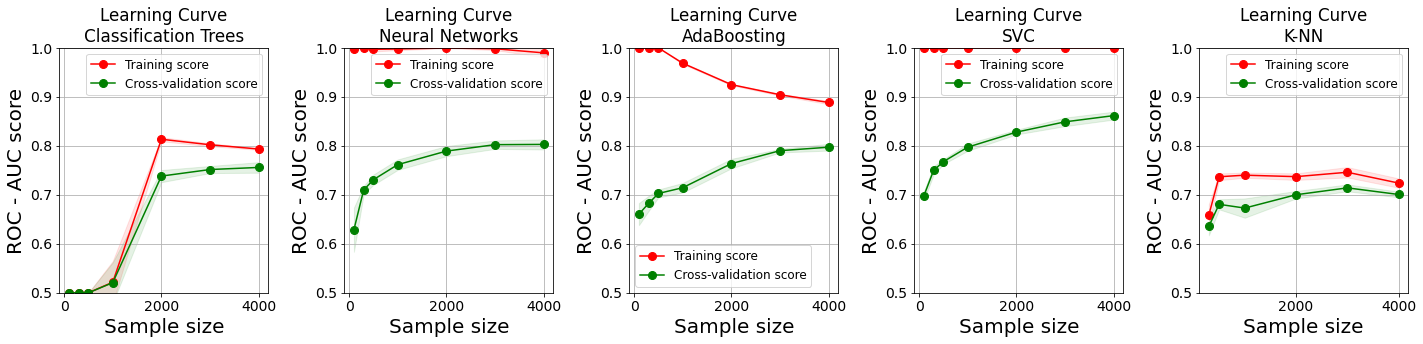

In [273]:
# PLot the final learning curves
figure = plt.figure(figsize = (20, 5))

for idx, modelName in enumerate(randomSearchRes.keys()):
    
    ax = figure.add_subplot(1, 5, idx+1)
        
    # Plot Learning curve
    title = 'Learning Curve\n' + modelName    
    train_sizes, train_scores, test_scores, fit_times, _ = tunedModelsResults[modelName]['learning_curve_data']
    plots.plotLearningCurve(train_sizes, train_scores, test_scores, ax, title, ylabel = 'ROC - AUC score')
    
    ax.set_ylim([0.5, 1.0])

figure.tight_layout()


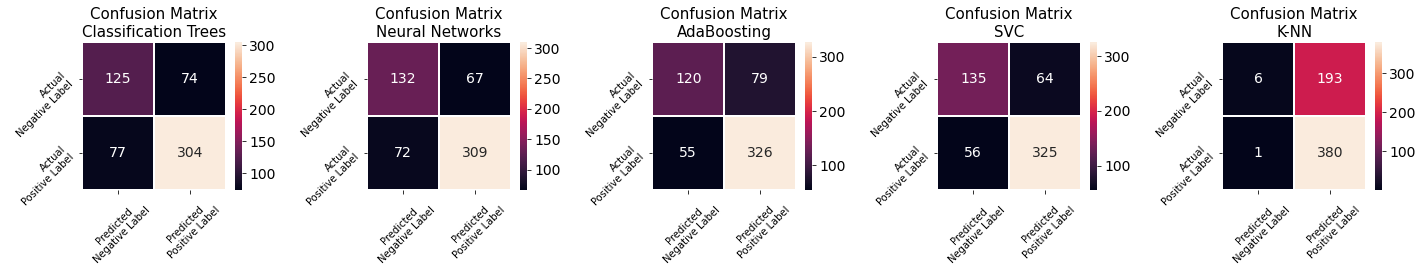

In [274]:
# PLot the confusion matrices
figure = plt.figure(figsize = (20, 4))

for idx, modelName in enumerate(randomSearchRes.keys()):
    
    ax = figure.add_subplot(1, 5, idx+1)
        
    # Plot Learning curve
    title = 'Learning Curve\n' + modelName    
    y_pred = tunedModelsResults[modelName]['y_pred']
    title = "Confusion Matrix\n" + modelName
    plots.plot_confusion_matrix(y_pred, y_test, ax, title, ylabel = 'ROC - AUC score')

figure.tight_layout()
figure.savefig(os.path.join(os.path.join(OUTFIGURES, "confusion_matrices_tuned_models.png")))

### Analyze the examples that SVC gets wrong

In [276]:
modelName = 'SVC'
tunedModelsResults[modelName]["y_pred"]!=y_test

4437    False
341     False
1424     True
2732    False
3865    False
        ...  
2952    False
1058     True
5183     True
1861     True
2320    False
Name: target, Length: 580, dtype: bool

In [295]:
x=raw['msge'].copy()
y=raw['target'].copy()
X_train,X_test, y_train, y_test= train_test_split(x,y, test_size= 0.1, random_state=30)

In [303]:
X_test.loc[tunedModelsResults[modelName]["y_pred"]!=y_test].iloc[20]

'Take Profits & Tighten stops. SA indicating major correction looms.  OCN NSM EGN BID GMC FB NKD'

In [302]:
y_test.iloc[20]

1

In [299]:
X_test.loc[tunedModelsResults[modelName]["y_pred"]==y_test].iloc[1]

'AYI 2013 Q1 operational Cash flow negative 14.5 million. decline of 41 million vs. Q1 2012.  152% decline'

In [300]:
y_test.iloc[1]

0